In [1]:
import os
import glob

import datetime as dt
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from scipy.ndimage import zoom, distance_transform_edt, generic_filter, median_filter, gaussian_filter
import cmocean.cm as cm

import numpy as np
import scipy as sp
import scipy.ndimage
from tqdm import tqdm

%matplotlib inline

In [2]:
def fill_gaps_nn(array, distance=2, mask=None):
    """ Fill gaps in input array
    # https://stackoverflow.com/questions/5551286/filling-gaps-in-a-numpy-array/9262129#9262129
    Parameters
    ----------
    array : 2D numpy.array
        Raster with data
    distance : int
        Minimum size of gap to fill
    mask : 2D numpy.array
        Raster with True where to fill gaps
    Returns
    -------
    array : 2D numpy.array
        Raster with data with gaps filled
    """
    if mask is None:
        mask = np.isnan(array)
    dist, indi = distance_transform_edt(mask, return_distances=True, return_indices=True)
    gpi = dist <= distance
    r, c = indi[:, gpi]
    array = np.array(array)
    array[gpi] = array[r, c]
    return array

def gaussian_filter_nan(a, sigma, truncate):
    b = a.copy()
    b[np.isnan(a)]=0
    bb = gaussian_filter(b, sigma=sigma, truncate=truncate)

    w = np.ones_like(b)
    w[np.isnan(b)] = 0
    ww = gaussian_filter(w, sigma=sigma, truncate=truncate)

    return bb / ww

def filter_3d_array(array, ice_mask, distance=5, gauss_filter_kernel=(0.5, 1., 1.), truncate=2):
    mask = np.isnan(array)
    dist, indi = distance_transform_edt(mask, return_distances=True, return_indices=True)
    gpi = dist <= distance
    r,c,i = indi[:, gpi]
    array_f1 = np.array(array)
    array_f1[gpi] = array[r,c,i]
    array_f2 = gaussian_filter(array_f1, gauss_filter_kernel, truncate=truncate)
    array_f2[ice_mask] = np.nan
    return array_f2

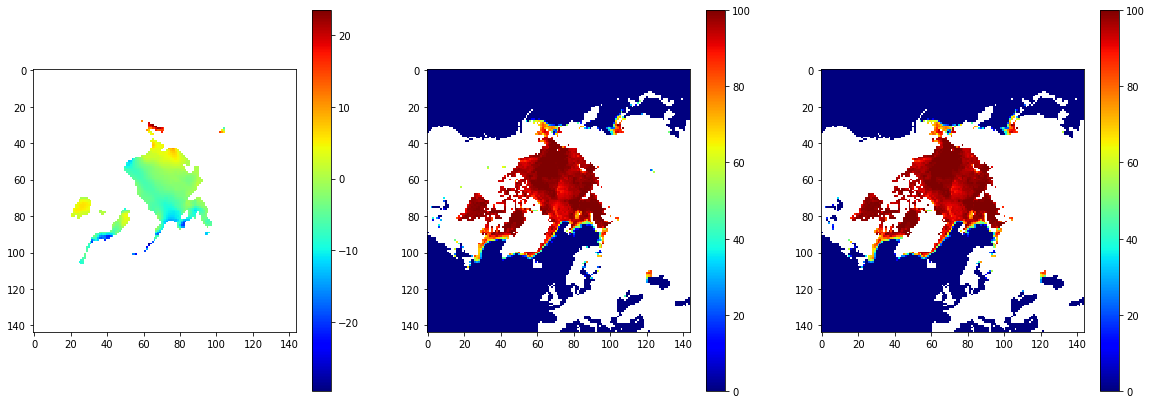

(144, 144) (144, 144) (144, 144)


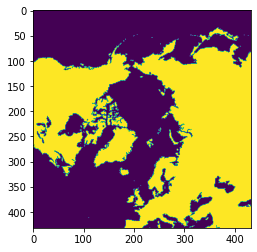

In [3]:
#!ncdump -h /data1/antonk/tardis/osisaf/sic_cdr_v3p0/1991/01/ice_conc_nh_ease2-250_cdr-v3p0_199101011200.nc
sid_file = '/Data/sim/data/OSISAF_ice_drift_CDR_v1p0_merged//1991/01/ice_drift_nh_ease2-750_cdr-v1p0_24h-199101011200.nc'
sic_file1 = '/Data/sim/data/OSISAF_ice_conc_CDR/1991/01/ice_conc_nh_ease2-250_cdr-v2p0_199101011200.nc'
sic_file2 = '/data1/antonk/tardis/osisaf/sic_cdr_v3p0/1991/01/ice_conc_nh_ease2-250_cdr-v3p0_199101011200.nc'

with Dataset(sic_file1) as dds:
    sic1 = dds['ice_conc'][0]

with Dataset(sic_file2) as dds:
    sic2 = dds['ice_conc'][0].filled(np.nan)
    status_flag = dds['status_flag'][0]
    
with Dataset(sid_file) as dds:
    dx = dds['dX'][0]


fig, axs = plt.subplots(1,3, figsize=(20,7))
plt.colorbar(axs[0].imshow(dx, cmap='jet', interpolation='nearest'), ax=axs[0])
plt.colorbar(axs[1].imshow(sic1[1:-1:3, 1:-1:3], cmap='jet', clim=[0, 100], interpolation='nearest'), ax=axs[1])
plt.colorbar(axs[2].imshow(sic2[1:-1:3, 1:-1:3], cmap='jet', clim=[0, 100], interpolation='nearest'), ax=axs[2])
plt.show()

print(dx.shape, sic1[1:-1:3, 1:-1:3].shape, sic2[1:-1:3, 1:-1:3].shape,)

plt.imshow(status_flag % 2 == 1)
plt.show()

In [4]:
sic_dir = '/Data/sim/data/OSISAF_ice_conc_CDR/'
sid_dir = '/Data/sim/data/OSISAF_ice_drift_CDR_v1p0_merged/'

In [8]:
min_date = dt.datetime(2004,5,1)
max_date = dt.datetime(2004,5,30)

date = min_date
dates = []
while date < max_date:
    dates.append(date)
    date += dt.timedelta(1)

file_name_format = f'{sid_dir}/%Y/%m/ice_drift_nh_ease2-750_cdr-v1p0_24h-%Y%m%d1200.nc'
sid_files = [date.strftime(file_name_format) for date in dates]
print(len(sid_files), sid_files[0], sid_files[-1])

29 /Data/sim/data/OSISAF_ice_drift_CDR_v1p0_merged//2004/05/ice_drift_nh_ease2-750_cdr-v1p0_24h-200405011200.nc /Data/sim/data/OSISAF_ice_drift_CDR_v1p0_merged//2004/05/ice_drift_nh_ease2-750_cdr-v1p0_24h-200405291200.nc


In [9]:
# READ ALL SID DATA
#"""
ddx = []
ddy = []
dun = []

for sid_file in sid_files:
    with Dataset(sid_file) as dds:
        ddx.append(dds['dX'][0].filled(np.nan))
        ddy.append(dds['dY'][0].filled(np.nan))
        dun.append(dds['uncert_dX_and_dY'][0].filled(np.nan))

ddx = np.array(ddx)
ddy = np.array(ddy)
dun = np.array(dun)
#"""

"""
odir = '/data1/antonk/tardis/osisaf'
raw_file = f'{odir}/dx_dy_un_raw.npz'
#np.savez_compressed(raw_file, dx=ddx, dy=ddy, un=dun)

# reload pre-saved data
ddx = np.load(raw_file)['dx']
ddy = np.load(raw_file)['dy']
dun = np.load(raw_file)['un']
#"""

print(ddx.shape)

(29, 144, 144)


In [11]:
#"""
# READ ALL SIC DATA
sic_file_format = '/data1/antonk/tardis/osisaf/sic_cdr_v3p0/%Y/%m/ice_conc_nh_ease2-*_%Y%m%d1200.nc'
sic_files = [date.strftime(sic_file_format) for date in dates]
print(len(sic_files), sic_files[0], sic_files[-1])
sic_all = {}
siu_all = {}

for sic_file, date in tqdm(zip(sic_files, dates)):
    if date in sic_all:
        continue
    match_files = glob.glob(sic_file)
    if len(match_files) > 0:
        with Dataset(match_files[0]) as dds:
            conc = dds['ice_conc'][0]
            unce = dds['total_standard_uncertainty'][0]
    else:
        print(f'Not existing! {sic_file}')
    sic_all[date] = conc
    siu_all[date] = unce
si_con = np.array([sic_all[date] for date in dates])
si_unc = np.array([siu_all[date] for date in dates])
si_con[si_con < 0] = np.nan
si_unc[si_unc < 0] = np.nan
#"""

#raw_sic_file = f'{odir}/sic_raw.npz'
#np.savez_compressed(raw_sic_file, si_con=si_con, si_unc=si_unc)
#si_con = np.load(raw_sic_file)['si_con']
#si_unc = np.load(raw_sic_file)['si_unc']
print(si_con.shape)

29 /data1/antonk/tardis/osisaf/sic_cdr_v3p0/2004/05/ice_conc_nh_ease2-*_200405011200.nc /data1/antonk/tardis/osisaf/sic_cdr_v3p0/2004/05/ice_conc_nh_ease2-*_200405291200.nc


29it [00:00, 85.86it/s]


(29, 432, 432)


In [12]:
# filter data without noise
# mask by low concentration
# remove concentration, where ice drift is not given

min_sic = 15
distance = 10
ice_mask = (si_con[:, 1:-1:3, 1:-1:3] < min_sic) + np.isnan(si_con[:, 1:-1:3, 1:-1:3])

ddxf00 = filter_3d_array(ddx, ice_mask, distance=distance)
ddyf00 = filter_3d_array(ddy, ice_mask, distance=distance)


In [ ]:
#filtered_file = f'{odir}/dx_dy_sic_unc_f00.npz'
#np.savez_compressed(filtered_file, dx=ddxf00, dy=ddyf00, sic=si_con, unc=si_unc)

In [17]:
# save exactly the same format as v1pre
# for a given range of dates
# note the SIGN in np.savez(..., -ddyf00, ...)

odir = '/data1/antonk/tardis/osisaf/sic_cdr_v3p0/postproc'
save_min_date = dt.datetime(2004,5,19)
save_max_date = dt.datetime(2004,5,20)
save_dates = [save_min_date + dt.timedelta(i) for i in range((save_max_date - save_min_date).days)]

for i, date in tqdm(enumerate(dates)):
    if date in save_dates:
        osubdir = date.strftime(f'{odir}/%Y')
        os.makedirs(osubdir, exist_ok=True)
        ofile = f'{osubdir}/ice_drift_nh_ease2-750_cdr-v1p0_24h-{date.strftime("%Y%m%d")}1200.nc.npz'
        print(date, ofile)
        np.savez(ofile, u=ddxf00[i], v=-ddyf00[i], c=si_con[i])


29it [00:00, 1538.43it/s]

2004-05-19 00:00:00 /data1/antonk/tardis/osisaf/sic_cdr_v3p0/postproc/2004/ice_drift_nh_ease2-750_cdr-v1p0_24h-200405191200.nc.npz


In [ ]:
# add noise, filter and save (10 times)
dun_sqrt = dun ** 0.5
for i in range(1, 10):
    noisy_filtered_file = f'{odir}/dx_dy_f{i:02}.npz'
    print(noisy_filtered_file)
    dxy_noisy_filt = [filter_3d_array(dxy + np.random.randn(*dun.shape)*dun_sqrt) for dxy in [ddx, ddy]]
    np.savez_compressed(noisy_filtered_file, dx=dxy_noisy_filt[0], dy=dxy_noisy_filt[1])


In [ ]:
# sanity check of random data
dxf = {j: np.load(f'{odir}/dx_dy_f{j:02}.npz')['dx'][::10] for j in range(10)}
dyf = {j: np.load(f'{odir}/dx_dy_f{j:02}.npz')['dy'][::10] for j in range(10)}
params = dict(
    clim=[-20,20],
    cmap=cm.balance,
    interpolation='nearest'
)

for i in np.floor(np.linspace(0, dxf[0].shape[0]-1, 10)).astype(int):
    print(dates[::10][i])
    fig, axs = plt.subplots(2,10, figsize=(30,6), sharex=True, sharey=True)
    for j in range(10):
        axs[0,j].imshow(dxf[j][i], **params)
        axs[1,j].imshow(dyf[j][i], **params)
    plt.show()
